# Basic neural network implemented by Theano

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

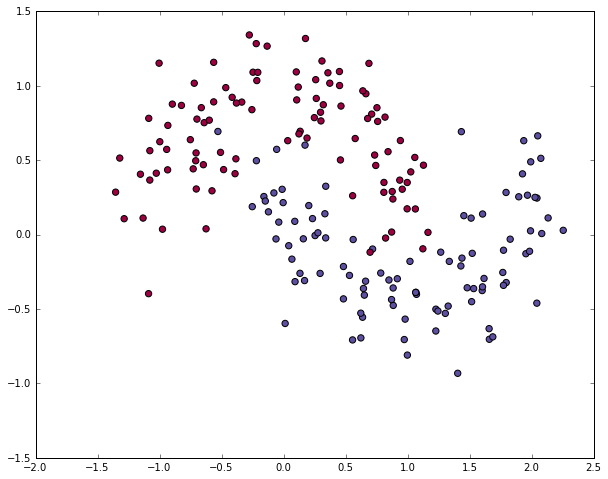

In [2]:
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [3]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [4]:
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 100 # hiden layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

In [5]:
X=T.matrix('X')
y=T.lvector('y')

In [6]:
W1=theano.shared(np.random.randn(nn_input_dim,nn_hdim),name='W1')
b1=theano.shared(np.zeros(nn_hdim),name='b1')
W2=theano.shared(np.random.randn(nn_hdim,nn_output_dim),name='W2')
b2=theano.shared(np.zeros(nn_output_dim),name='b2')

In [7]:
z1=X.dot(W1)+b1
a1=T.tanh(z1)
z2=a1.dot(W2)+b2
y_hat=T.nnet.softmax(z2)

loss_reg=1./num_examples*reg_lambda/2*(T.sum(T.sqr(W1))+T.sum(T.sqr(W2)))

loss=T.nnet.categorical_crossentropy(y_hat,y).mean()+loss_reg

prediction=T.argmax(y_hat,axis=1)

In [8]:
forward_prop=theano.function([X],y_hat)
calculate_loss=theano.function([X,y],loss)
predict=theano.function([X],prediction)

In [10]:
forward_prop([[1,2]])

array([[  2.83629516e-04,   9.99716370e-01]])

In [12]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [@A] ''   4
 |Dot22 [@B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [@C] ''   2
 | | |Dot22 [@D] ''   1
 | | | |X [@E]
 | | | |W1 [@F]
 | | |InplaceDimShuffle{x,0} [@G] ''   0
 | |   |b1 [@H]
 | |W2 [@I]
 |b2 [@J]


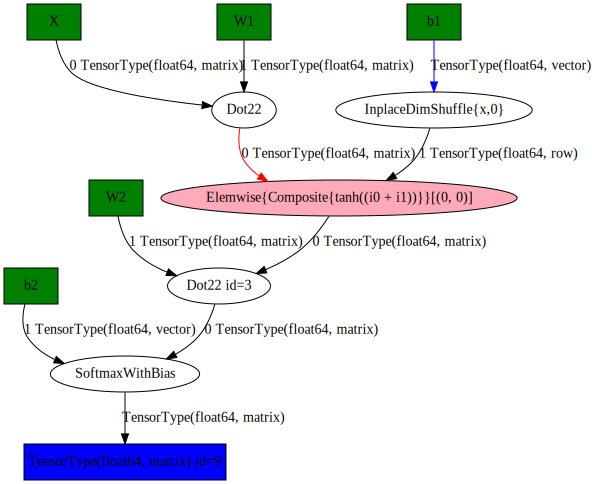

In [13]:
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

In [14]:
dW2=T.grad(loss,W2)
db2=T.grad(loss,b2)
dW1=T.grad(loss,W1)
db1=T.grad(loss,b1)

In [15]:
gradient_step=theano.function([X,y],updates=((W2,W2-epsilon*dW2),(W1,W1-epsilon*dW1),(b1,b1-epsilon*db1),(b2,b2-epsilon*db2)))

In [21]:
def Build_model(num_passes=20000,print_loss=False):
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    for i in xrange(num_passes):
        gradient_step(train_X,train_y)
        
        if print_loss % num_passes%1000==0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

In [22]:
Build_model(print_loss=True)

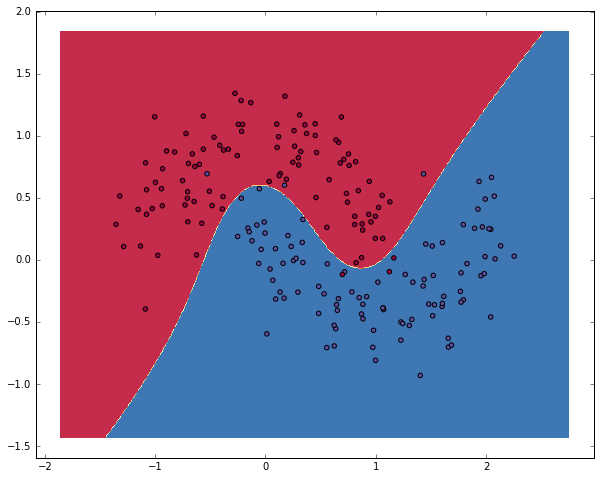

In [23]:
plot_decision_boundary(lambda x: predict(x))